In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from heatmap import HeatMap as hm
import h5py
import matplotlib.animation as animation
from simulation import individual_simulation as sim_
import matplotlib.gridspec as gridspec
import tensorflow as tf

2024-09-29 01:23:34.132929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 01:23:34.146609: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 01:23:34.150700: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-29 01:23:34.160702: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-29 01:23:34.919698: W tensorflow/compiler/tf2

In [54]:
def cost_col(path, name, range_):
    cost = []
    time = []
    total_slices = 0
    num_cost = []
    data = h5py.File(path + name + f"{3}.h5", "r")
    target = data["target"][:]
    for i in range(range_[0], range_[1]):
        data = h5py.File(path + name + f"{i}.h5", "r")
        time.extend(data["time"])
        cost.extend(list(data["cost"]))
        num_cost.append(len(list(data["cost"])))
        data.close()

    res_ = np.zeros((len(cost), 100, 100))

    inx = 0
    h = 0
    for j in range(range_[0], range_[1]):
        data = h5py.File(path + name + f"{j}.h5", "r")
        _, y, x = data["results"].shape
        res_[inx:inx + num_cost[h], :, :] = data["results"][:num_cost[h], :, :] 
        inx += num_cost[h]
        h += 1
        data.close()

    return cost, res_, target, time   

In [55]:
# check the files pathway
path = "/home/samani/Documents/projects/master_project/model/results/model_3/"
#file = h5py.File(path, "r")
#ind = file["ind"][:]
#print(file.keys())

In [56]:
# data extraction from the files
name = "datasets"
cost, res_, target, time = cost_col(path=path, name=name, range_=(1, 11))

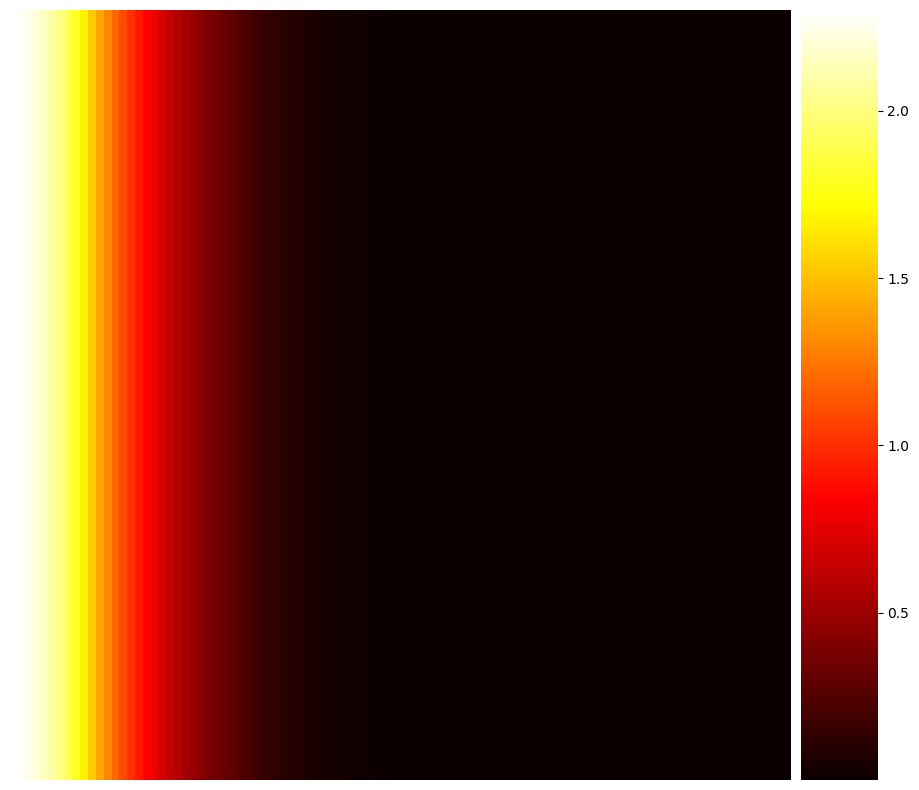

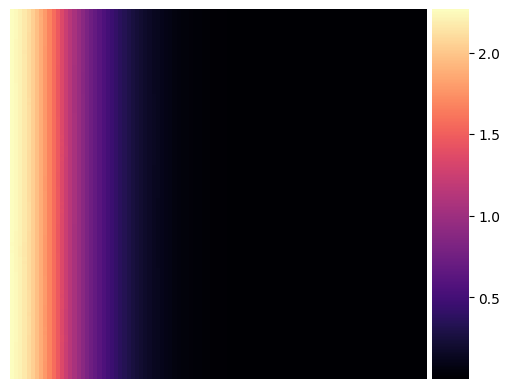

<Figure size 640x480 with 0 Axes>

In [71]:
# target heatmap (inferno, plasma, cividis, viridis, magma and hot)
plt.figure(figsize=(12, 10))
sns.heatmap(target, cmap="hot", cbar_kws={"aspect": 10, "pad": 0.01})
plt.axis('off')
plt.savefig("/home/samani/Documents/projects/master_project/model/results/model_3/target.png")
plt.show()
plt.clf()

sns.heatmap(res_[-1, :, :], cmap="magma", cbar_kws={"aspect": 10, "pad": 0.01})
plt.axis('off')
#plt.savefig(r"C:\Users\yda2\Downloads\projects\master_project\model\results\model_3\y_hat")
plt.show()
plt.clf()

In [16]:
# cost cleaning
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
sm_ = moving_average(c_final, window_size=5)

245


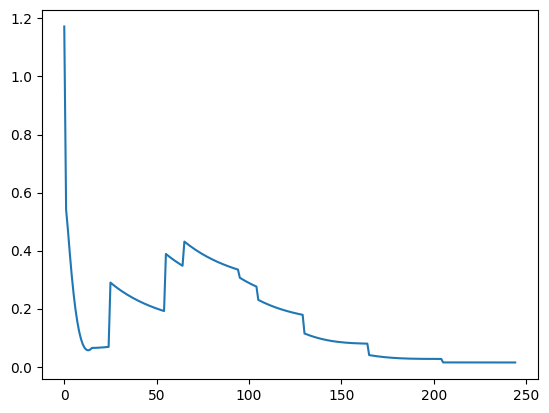

In [62]:
c1 = cost[:3]
c2 = cost[68:]
c_final = c1 + c2
plt.plot(cost)
print(len(cost))

(245, 100, 100)


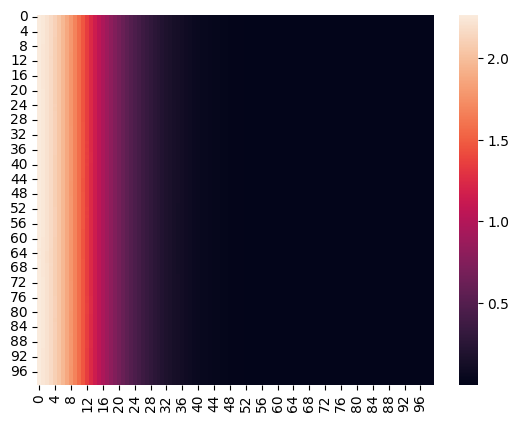

In [36]:
sns.heatmap(res_[-1, :, :])
print(res_.shape)

In [67]:
# heat map video
def generate_heatmap_video(results, cmap='plasma', save_path='heatmap_video.mp4', dpi=300, fps=10, bitrate=2000,
                           cbar_shrink=0.8, cbar_aspect=20, cbar_pad=0.01):
    iterations, y, x = results.shape
    fig = plt.figure(figsize=(10, 8), dpi=dpi)
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.02], wspace=0.02)
    ax = fig.add_subplot(gs[0, 0]) 
    cbar_ax = fig.add_subplot(gs[0, 1])
    cax = ax.imshow(results[0, :, :], cmap=cmap, vmin=np.min(results), vmax=np.max(results))
    fig.colorbar(cax, cax=cbar_ax, shrink=cbar_shrink, aspect=cbar_aspect, pad=cbar_pad)

    ax.set_xticks([])
    ax.set_yticks([])

    def update(i):
        cax.set_data(results[i, :, :])
        ax.set_title(f"Iteration {i}")
        
    ani = animation.FuncAnimation(fig, update, frames=iterations, repeat=False)
    ani.save(save_path, writer='ffmpeg', fps=fps, bitrate=bitrate, dpi=dpi)

    plt.close()

In [69]:
generate_heatmap_video(
    res_, cmap='hot', save_path='model_3.mp4',dpi=300, fps=10, bitrate=2000,
    cbar_shrink=0.8, cbar_aspect=0, cbar_pad=0.01)

In [81]:
data = h5py.File("/home/samani/Documents/projects/master_project/model/results/model_3/datasets10.h5")
print(data.keys())
ind = data["ind"]
print(ind.shape)

<KeysViewHDF5 ['cost', 'ind', 'results', 'target', 'time']>
(3, 100, 100)


In [45]:
print(res_.shape)

(245, 100, 100)


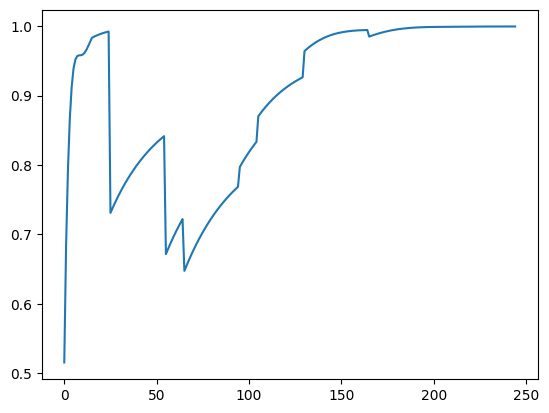

In [75]:
# calculate accuracies

accuracies = []
for i in range(245):
    mse = np.mean((res_[i, :, :] - target) ** 2)
    max_possible_error = 1 ** 2
    accuracy = 1 - mse / max_possible_error
    accuracies.append(accuracy)
plt.plot(accuracies)

In [78]:
# cost animation
def generate_cost_accuracy_animation(costs, accuracies, save_path='cost_accuracy_progression.gif', dpi=300, fps=10, bitrate=2000):
    
    fig, ax = plt.subplots(figsize=(16, 6), dpi=dpi)
    ax.set_xlim(-5, len(costs)+5)  
    ax.set_ylim(-.05, 1.2)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Values")
    
    cost_line, = ax.plot([], [], lw=4, color='darkred', label="Cost") 
    accuracy_line, = ax.plot([], [], lw=4, color='gold', label="Accuracy")

    cost_point = ax.plot([], [], marker='o', color='darkred', markersize=10)[0]  
    accuracy_point = ax.plot([], [], marker='o', color='gold', markersize=10)[0]  

    title = ax.text(0.5, 1.2, '', transform=ax.transAxes, ha="center", fontsize=16)
    ax.legend(loc='upper right')

    def init():
        cost_line.set_data([], [])
        accuracy_line.set_data([], [])
        cost_point.set_data([], [])
        accuracy_point.set_data([], [])
        title.set_text('')
        return cost_line, accuracy_line, cost_point, accuracy_point, title

    def update(i):
        x = np.arange(i + 1) 
        cost_y = costs[:i + 1]  
        accuracy_y = accuracies[:i + 1] 
        cost_line.set_data(x, cost_y)
        accuracy_line.set_data(x, accuracy_y)
        cost_point.set_data(i, costs[i]) 
        accuracy_point.set_data(i, accuracies[i]) 
        title.set_text(f"Cost & Accuracy - {i}")
        return cost_line, accuracy_line, cost_point, accuracy_point, title

    ani = animation.FuncAnimation(fig, update, frames=len(costs), init_func=init, blit=True, repeat=False)
    ani.save(save_path, writer='ffmpeg', fps=fps)
    plt.close()

In [79]:
generate_cost_accuracy_animation(cost, accuracies, save_path='cost_accuracy_progression1_.mp4')

/tmp/ipykernel_43254/1317346609.py:33: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  cost_point.set_data(i, costs[i])
/tmp/ipykernel_43254/1317346609.py:34: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  accuracy_point.set_data(i, accuracies[i])


In [38]:
ac = data["accuracy"][:]/100
print(ac)

[0.45682758 0.47792765 0.49806327 0.51721372 0.53541085 0.55265625
 0.56900637 0.58452977 0.59924361 0.61320647 0.62645512 0.63901764
 0.65094171 0.66226026 0.672999   0.68319571 0.69288674 0.70208903
 0.71084248 0.71916342 0.7270847  0.73461647 0.74177734 0.74860193
 0.75510892 0.76131686 0.76723263 0.77287764 0.77826259 0.78340772
 0.78831969 0.79301384 0.79750113 0.80178694 0.80588193 0.80979792
 0.81354694 0.81714044 0.82058307 0.82388057 0.82704065 0.83007009
 0.83297496 0.83576298 0.83844077 0.84101355 0.84348664 0.84586416
 0.84814904 0.85034501 0.85245768 0.85449016 0.85644685 0.85833078
 0.86014658 0.81592828 0.82460233 0.83284873 0.84063206 0.84794073
 0.854805   0.86124502 0.86728888 0.87295818 0.8782914  0.88329555
 0.8880032  0.89242432 0.89657821 0.90048298 0.9041611  0.90761962
 0.91087342 0.91393787 0.91682769 0.92705239 0.93110104 0.93492755
 0.93851113 0.94186609 0.94499735 0.94791534 0.95063439 0.9531629
 0.9555148  0.95771042 0.95975265 0.96165526 0.96343054 0.96508

In [82]:
# store the cleaned data
with h5py.File("/home/samani/Documents/projects/master_project/model/results/model_3/data.h5", 'a') as h5file:
    h5file.create_dataset("ind", data=ind)
    h5file.create_dataset("time", data=np.array(time))
    h5file.create_dataset("cost", data=np.array(cost))
    h5file.create_dataset("target", data=target)
    h5file.create_dataset("y_hat", data=res_)
    h5file.create_dataset("accuracy", data=np.array(accuracies))
    